In [1]:
import random
import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
#from subprocess import Popen, PIPE
#from pyfaidx import Fasta

In [2]:
link = 'D:/users/Marko/downloads/mirna/'

In [3]:
images = np.load(f'{link}/data/modmirbase_train_images.npz')['arr_0']/255

In [4]:
x_len = np.load(f'{link}/data/modmirbase_train_images_len.npz')
x_bar = np.load(f'{link}/data/modmirbase_train_images_bar.npz')

In [5]:
x_len_max = np.argmax(x_len, 1)

In [6]:
x_bar_max = np.argmax(x_bar, 1)

In [7]:
length_table = {('A','U'):2,('U','A'):2,('C','G'):1,
                    ('G','C'):1,('G','U'):3,('U','G'):3,
                    ('A','A'):4,('A','G'):4,('A','C'):4,
                    ('C','C'):4,('C','U'):4,('C','A'):4,
                    ('U','C'):4,('U','U'):4,('G','A'):4,
                    ('G','G'):1,('A','Z'):1,('Z','A'):1,
                    ('U','Z'):1,('Z','U'):1,('C','Z'):1,
                    ('Z','C'):1,('G','Z'):1,('Z','G'):1,
                    ('Z','Z'):1}

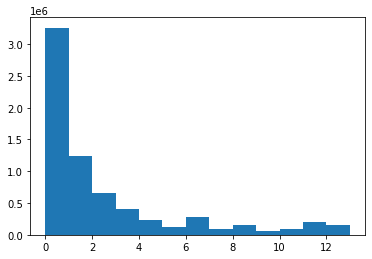

In [8]:
plt.hist(x_bar_max.flatten(), bins = np.arange(0,14,1));

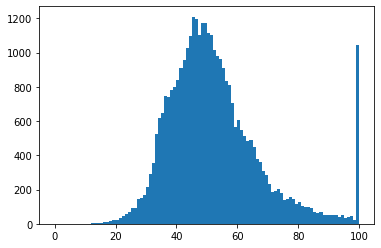

In [9]:
plt.hist(x_len_max, bins=np.arange(0,101,1));

In [10]:
def get_color(pixel):
    """
    returns the encoded value for a pixel
    """
    if (pixel == np.array([0,0,0])).all():  
        return 'Z' # black
    elif (pixel == np.array([1,0,0])).all():  
        return 'G' # red
    elif (pixel == np.array([0,0,1])).all():  
        return 'C' # blue
    elif (pixel == np.array([0,1,0])).all():  
        return 'U' # green
    elif (pixel == np.array([1,1,0])).all():  
        return 'A' # yellow
    else:
        print("Something wrong!")

In [11]:
def get_pixel(color):
    """
    returns the encoded value for a pixel
    """
    if color == 'Z': 
        return np.array([0,0,0])
    elif color == 'G':
        return np.array([1,0,0])
    elif color == 'C':
        return np.array([0,0,1])
    elif color == 'U': 
        return np.array([0,1,0])
    elif color == 'A':
        return np.array([1,1,0])
    else:
        print("Something wrong!")

In [12]:
top = []
bot = []
top_bonds = []
bot_bonds = []
for i in tqdm(range(images.shape[0])):
    topstr=''
    botstr=''
    top_bond = []
    bot_bond = []
    for j in range(x_len_max[i]+1):
        top_col = get_color(images[i,12,j])
        bot_col = get_color(images[i,13,j])

        topstr+=top_col
        botstr+=bot_col
        
        if top_col == 'Z':
            top_bond.append('-')
        elif x_bar_max[i, 2*j] == length_table[top_col, bot_col]:
            top_bond.append('|')
        else:
            top_bond.append('.')
        
        if bot_col == 'Z':
            bot_bond.append('-')
        elif x_bar_max[i, 1+2*j] == length_table[top_col, bot_col]:
            bot_bond.append('|')
        else:
            bot_bond.append('.')
    top.append(topstr)
    bot.append(botstr)
    top_bonds.append(top_bond)
    bot_bonds.append(bot_bond)

100%|███████████████████████████████████████████████████████████████████████████| 34721/34721 [01:01<00:00, 563.14it/s]


In [13]:
def swap_nucleotides(top, bot, top_bond, bot_bond, lent, prob=.2):
    for i in range(8,lent):
        if np.random.uniform() < prob:
            top[i], bot[i] = bot[i],top[i]
            top_bond[i], bot_bond[i] = bot_bond[i], top_bond[i]
    
    return top, bot, top_bond, bot_bond

In [47]:
def change_gap(top, bot, top_bond, bot_bond, lent, prob_fill=.2, prob_remove=.2):
    for i in range(8,lent):
        if top[i] != 'Z' and bot[i] != 'Z':
            if np.random.uniform() < prob_remove:
                if np.random.uniform() < .5:
                    top[i] = "Z"
                    top_bond[i] = '-'
                    bot_bond[i] = '.'
                else:
                    bot[i] = "Z"
                    top_bond[i] = '.'
                    bot_bond[i] = '-'

        else:
            if top[i] == "Z" and np.random.uniform() < prob_fill:
                top[i] = get_matching_color(bot[i])
                # we are getting a matching color -> always results in good bond
                top_bond[i] = '|'
                bot_bond[i] = '|'

            if bot[i] == "Z" and np.random.uniform() < prob_fill:
                bot[i] = get_matching_color(top[i])
                top_bond[i] = '|'
                bot_bond[i] = '|'
    return top, bot, top_bond, bot_bond

In [48]:
def change_bond(top, bot, top_bond, bot_bond, lent, prob_make_strong=.1, prob_make_weak=.1):
    for i in range(8, lent):
        if is_strong_bond(top[i],bot[i]):
            if np.random.uniform() < prob_make_weak:
                top[i], bot[i] = get_weak_bond()
                top_bond[i] = '.'
                bot_bond[i] = '.'
        else:
            if np.random.uniform() < prob_make_strong:
                top[i], bot[i] = get_strong_bond()
                top_bond[i] = '|'
                bot_bond[i] = '|'
    return top, bot, top_bond, bot_bond

In [49]:
def mix_chunks(top, bot, top_bond, bot_bond, lent, prob=.3, prob_reverse=.3,chunk_length=9):
    chunks = []
    chunk_idx = np.arange((lent-8)//chunk_length+1)
    shuffle_list=[]
    shuffle_dict={}
    
    for i in chunk_idx:
        shuffle_dict[i] = i
        if np.random.uniform()<prob_reverse:
            chunks.append(np.arange(8+i*chunk_length, min(8+(i+1)*chunk_length, lent+1))[::-1])
        else:
            chunks.append(np.arange(8+i*chunk_length, min(8+(i+1)*chunk_length, lent+1)))
        if np.random.uniform()<prob:
            shuffle_list.append(i)
    shuf = shuffle_list.copy()
    random.shuffle(shuf)
    
    for i in range(len(shuffle_list)):
        shuffle_dict[shuffle_list[i]] = shuf[i] 
    
    chunks = [chunks[i] for i in shuffle_dict.values()]
    
    order = [i for i in range(8)]+[i for item in chunks for i in item]
    print(len(order), len(top))
    top = [top[i] for i in order]
    bot = [bot[i] for i in order]
    
    top_bond = [top_bond[i] for i in order]
    bot_bond = [bot_bond[i] for i in order]
    return top, bot, top_bond, bot_bond

In [50]:
def get_matching_color(nt):
    if nt == 'A':
        return 'U'
    if nt == 'U':
        return np.random.choice(['A','G'], p=[.7,.3])
    if nt == 'C':
        return 'G'
    if nt == 'G':
        return np.random.choice(['C','U'], p=[.8,.2])
    if nt == 'Z':
        return 'Z'

In [51]:
def is_strong_bond(nt1, nt2):
    if (nt1 == 'A' and nt2 == 'U') or (nt1 == 'U' and nt2 == 'A'):
        return True
    elif (nt1 == 'C' and nt2 == 'G') or (nt1 == 'G' and nt2 == 'C'):
        return True
    elif (nt1 == 'U' and nt2 == 'G') or (nt1 == 'G' and nt2 == 'U'):
        return True
    else:
        return False

In [52]:
def get_weak_bond():
    choices = [('A','A'),('A','G'),('A','C'),('C','C'),('C','U'),('C','A'),('U','C'),('U','U'),('G','A'),('G','G')]
    return choices[np.random.choice(len(choices))]

In [53]:
def get_strong_bond():
    choices = [('A','U'),('U','A'),('C','G'),('G','C'),('G','U'),('U','G')]
    return choices[np.random.choice(len(choices))]

In [54]:
def reconstruct_image(top, bot, top_bond, bot_bond, rna_length):

    image = np.ones((25,100,3))
    for i in range(len(top)):
        lnt = length_table[(top[i],bot[i])]
        
        lnt_top = calc_length(top, bot, top_bond, bot_bond, lnt, i, 'top', rna_length)
        lnt_bot = calc_length(top, bot, top_bond, bot_bond, lnt, i, 'bot', rna_length)
        
        
        image[max(12-lnt_top,0):13,i] = get_pixel(top[i])
        image[13:min(13+lnt_bot+1,25),i] = get_pixel(bot[i])
    return image
    
    

In [55]:
def calc_length(top, bot, top_bond, bot_bond, lnt, pos, strand, rna_length):
    if strand == 'top':
        strand = top_bond
    else:
        strand = bot_bond

    if strand[pos] == '.':
        tr = pos - 1
        tl = pos + 1


        
        while tr >= 0 and strand[tr] == '.':
            tr -= 1
        while tl <= rna_length and strand[tl] =='.':
            tl += 1

        dots = tr+tl+1
        mid = dots/2
        p = pos - tr

        if p > mid:
            k = dots+1
            while k > p:
                lnt += 2
                k -= 1
        else:
            k = 1
            while k <= p:
                lnt += 2
                k += 1
    return lnt

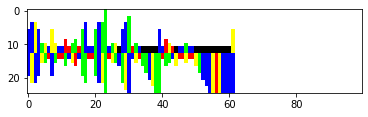

In [56]:
plt.imshow(reconstruct_image(top[10], bot[10], top_bonds[10], bot_bonds[10],  x_len_max[10]))

53 53


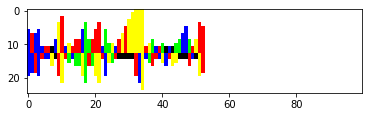

In [84]:
augment_mirna(110)

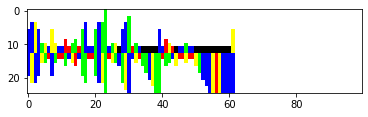

In [58]:
plt.imshow(images[10])

In [ ]:
print(top_bonds[10][-10:]), print(bot_bonds[10][-10:])

In [26]:
def augment_mirna(idx):
    lent = x_len_max[idx]
    tn = list(top[idx])
    bn = list(bot[idx])
    tb = top_bonds[idx].copy()
    bb = bot_bonds[idx].copy()
    
    tn,bn,tb,bb = swap_nucleotides(tn,bn,tb,bb,lent)
    tn,bn,tb,bb = change_gap(tn,bn,tb,bb,lent)
    tn,bn,tb,bb = change_bond(tn,bn,tb,bb,lent)
    tn,bn,tb,bb = mix_chunks(tn,bn,tb,bb,lent)
    rec = reconstruct_image(tn,bn,tb,bb,lent)
    
    plt.imshow(rec)

In [ ]:
print(top[0])
print(bot[0])

lent = x_len_max[0]

tn, bn = swap_nucleotides(list(top[0]),list(bot[0]),top_bonds,lent,0.2)
tn, bn = change_gap(tn,bn,lent,0.2)
tn, bn = change_bond(tn,bn,lent,0.15)
print("".join(tn))
print("".join(bn))

In [ ]:
weird = images[(x_len_max == 99)]

In [ ]:
#x_len[(x_len_max == 0)][0]

In [ ]:
plt.imshow(weird[0])